# ML Pipeline for Time-Series Forecasting and Anomaly Detection with SSMs

In [270]:
import numpy as np
import scipy
import os
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
import logging
import itertools
import matplotlib.pyplot as plt
from pyod.models.loci import LOCI
import pyflux as pf
from statsmodels.tsa.arima_model import ARIMA

In [240]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P),
                        (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [241]:
class ToxicityForecaster:
    
    DATA_PATH = "timeseries.csv"
    
    def __init__(self, ts, F=None, B=None, H=None, Q=None, R=None, P=None):
        self._init_logger()
        self.timeSeries = np.asarray(ts)
        self.kalman = KalmanFilter(F=F, B=B, H=H, Q=Q, R=R, P=P)
        
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
        
    def setKalmanParams(self, F=None, B=None, H=None, Q=None, R=None, P=None):
        self.kalman = KalmanFilter(F=F, B=B, H=H, Q=Q, R=R, P=P)

    def predict(self):
        self._logger.info('>>> Starting Latent State Prediction')
        observed, hidden = [], []
        for z in self.timeSeries:
            x = self.kalman.predict()
            hidden.append(x)
            observed.append(np.dot(self.kalman.H, x)[0])
            self.kalman.update(z)
        self._logger.info('>>> Completed Latent State Prediction')
        return observed, hidden
    
    def forecast(self, n_steps=50):
        observed, _ = self.predict()
        if not observed:
            return [], []
        forecasted = []
        self._logger.info('>>> Starting Forecasting')
        for i in range(n_steps):
            x = self.kalman.predict()
            z = np.dot(self.kalman.H, x)[0]
            forecasted.append(z)
            self.kalman.update(z)
        self._logger.info('>>> Completed Forecasting')
        observed = np.asarray(observed).flatten()
        forecasted = np.asarray(forecasted).flatten()
        return observed, forecasted

In [242]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)
x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

In [244]:
forecaster = ToxicityForecaster(measurements, F=F, H=H, Q=Q, R=R)
history, forecasted = forecaster.forecast()

2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 20:11:43,726 __main__     INFO     >>> Starting Latent State Prediction
2019

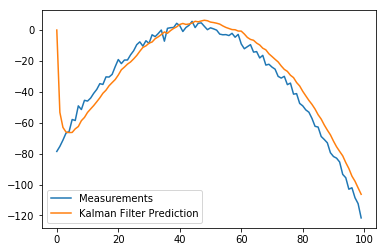

In [245]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(history)), np.array(history), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

### Look ahead time-series forecasting with SSMs

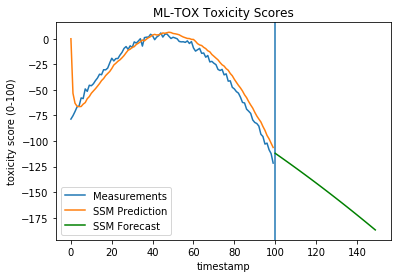

In [246]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.axvline(x=len(history))
plt.plot(range(len(history)), np.array(history), label = 'SSM Prediction')
plt.plot(range(len(history),len(history)+len(forecasted)), 
         np.array(forecasted), label = 'SSM Forecast', color='g')
plt.legend()
plt.title('ML-TOX Toxicity Scores')
plt.xlabel('timestamp')
plt.ylabel('toxicity score (0-100)')
plt.show()

In [54]:
import quandl
import datetime
quandl.ApiConfig.api_key = "oEsnZx8Dsss2HjXcU1Y3"
data = quandl.get_table('WIKI/PRICES', ticker = ['AAPL'], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2015-12-31', 'lte': '2016-12-31' }, 
                        paginate=True)
data.head()

,ticker,date,adj_close
None,,,
0,AAPL,2016-12-30,114.389454
1,AAPL,2016-12-29,115.288214
2,AAPL,2016-12-28,115.317843
3,AAPL,2016-12-27,115.811668
4,AAPL,2016-12-23,115.080808


In [307]:
df = data.copy()

In [308]:
df = df[['date','adj_close']].reset_index()
df = df[['date','adj_close']]
df.columns = ['timestamp','prediction']
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,timestamp,prediction
0,2016-12-30,114.389454
1,2016-12-29,115.288214
2,2016-12-28,115.317843
3,2016-12-27,115.811668
4,2016-12-23,115.080808


In [312]:
measurements = measurements.reshape(len(measurements),1)

In [313]:
import statsmodels.api as sm

# Fit a local level model
mod_var1 = sm.tsa.VARMAX(measurements, order=(1,0))
# Note that mod_var1 is an instance of the VARMAX class

# Fit the model via maximum likelihood
res_var1 = mod_var1.fit()
# Note that res_var1 is an instance of the VARMAXResults class

ValueError: Only gave one variable to VAR

In [292]:
measurements = df.prediction.values

In [300]:
model = ARIMA(measurements, order=(10,1,0))
model_fit = model.fit(disp=0)

In [301]:
forecasted = model_fit.forecast(100)[0]

In [302]:
forecasted

array([100.80669627, 100.63043042, 100.45028361, 100.98281235,
       101.44733761, 102.16534475, 102.14394489, 102.10722627,
       101.86086385, 101.71080404, 101.78316053, 101.85888444,
       101.99109388, 101.98876973, 101.97460299, 101.86020009,
       101.79388945, 101.7453822 , 101.72645132, 101.72701394,
       101.70027099, 101.66649184, 101.60612251, 101.55487718,
       101.50129572, 101.46232793, 101.42562214, 101.38724595,
       101.34616371, 101.29811651, 101.25084948, 101.20231637,
       101.15791788, 101.11374987, 101.07070543, 101.02646156,
       100.98089574, 100.9349712 , 100.88859309, 100.8431566 ,
       100.79782921, 100.7530405 , 100.70790255, 100.66260042,
       100.61702301, 100.57134616, 100.52582276, 100.48035301,
       100.4350532 , 100.38968539, 100.34431042, 100.29883085,
       100.2533344 , 100.20784245, 100.16237547, 100.11695034,
       100.07151967, 100.02609322,  99.98063725,  99.93517738,
        99.8897099 ,  99.84425129,  99.79880068,  99.75

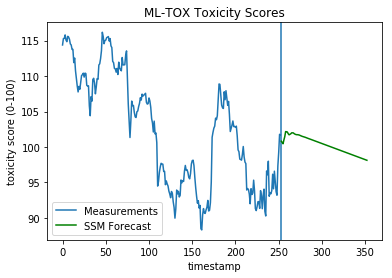

In [303]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.axvline(x=len(measurements))
plt.plot(range(len(measurements),len(measurements)+len(forecasted)), 
         np.asarray(forecasted), label = 'SSM Forecast', color='g')
plt.legend()
plt.title('ML-TOX Toxicity Scores')
plt.xlabel('timestamp')
plt.ylabel('toxicity score (0-100)')
plt.show()

In [ ]:
forecasted = []
for t in range(len(test)):
    model = ARIMA(measurements, order=(5,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    forecasted.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [267]:
from filterpy import kalman
from filterpy.common import Q_discrete_white_noise

my_filter = kalman.KalmanFilter(dim_x=2, dim_z=1)
my_filter.x = np.array([[0.],
                [0.]])       # initial state (location and velocity)

my_filter.F = np.array([[1.,1.],
                [0.,1.]])    # state transition matrix

my_filter.H = np.array([[1.,0.]])    # Measurement function
my_filter.P *= 1000.                 # covariance matrix
my_filter.R = 5                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(2, dt, .1) # process uncertainty

In [268]:
history = []
for z in measurements:
    my_filter.predict()
    current = np.dot(my_filter.F, my_filter.x)[0,0]
    my_filter.update(z)
    history.append(current)
history = np.asarray(history)

In [261]:
z = measurements[-1]
forecasted = []
for i in range(500):
    my_filter.predict()
    current = np.dot(my_filter.F, my_filter.x)[0,0]
    forecasted.append(current)
forecasted = np.asarray(forecasted)

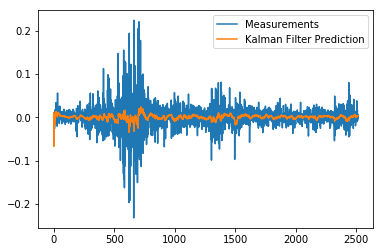

In [269]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(history)), np.array(history), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

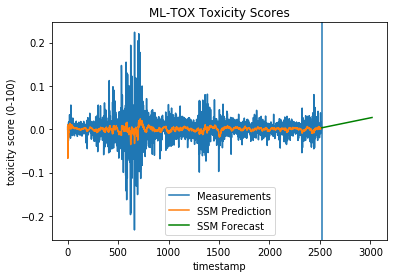

In [263]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.axvline(x=len(history))
plt.plot(range(len(history)), np.array(history), label = 'SSM Prediction')
plt.plot(range(len(history),len(history)+len(forecasted)), 
         np.array(forecasted), label = 'SSM Forecast', color='g')
plt.legend()
plt.title('ML-TOX Toxicity Scores')
plt.xlabel('timestamp')
plt.ylabel('toxicity score (0-100)')
plt.show()

In [257]:
from pandas_datareader.data import DataReader
a = DataReader('JPM',  'yahoo', pd.datetime(2006,6,1), pd.datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["prediction"]
a_returns.head()

,prediction
2006-06-02,0.005264
2006-06-05,-0.019360
2006-06-06,-0.013825
2006-06-07,-0.003073
2006-06-08,0.002364


In [258]:
measurements = a_returns.prediction.values
measurements.shape

(2518,)

In [10]:
forecaster = ToxicityForecaster(measurements, F=F, H=H, Q=Q, R=R)
history, forecasted = forecaster.forecast(n_steps=500)

2019-04-14 17:35:51,708 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 17:35:51,708 __main__     INFO     >>> Starting Latent State Prediction
2019-04-14 17:35:51,847 __main__     INFO     >>> Completed Latent State Prediction
2019-04-14 17:35:51,847 __main__     INFO     >>> Completed Latent State Prediction
2019-04-14 17:35:51,849 __main__     INFO     >>> Starting Forecasting
2019-04-14 17:35:51,849 __main__     INFO     >>> Starting Forecasting
2019-04-14 17:35:51,876 __main__     INFO     >>> Completed Forecasting
2019-04-14 17:35:51,876 __main__     INFO     >>> Completed Forecasting


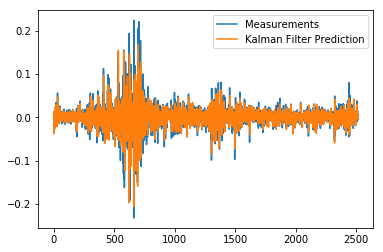

In [11]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(history)), np.array(history), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

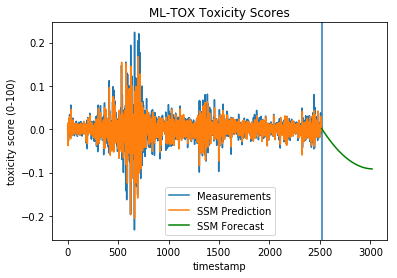

In [12]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.axvline(x=len(history))
plt.plot(range(len(history)), np.array(history), label = 'SSM Prediction')
plt.plot(range(len(history),len(history)+len(forecasted)), 
         np.array(forecasted), label = 'SSM Forecast', color='g')
plt.legend()
plt.title('ML-TOX Toxicity Scores')
plt.xlabel('timestamp')
plt.ylabel('toxicity score (0-100)')
plt.show()

### Anomaly detection for time-series

In [8]:
anomalyDetector = LOCI()
anomalyDetector.fit(history.reshape(-1,1))
anomalyLabels = np.asarray(anomalyDetector.labels_)
anomalyLabels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Experiment with pyflux time series forecasting

In [19]:
ts = pd.DataFrame({'prediction': measurements})
ts['timestamp'] = "2018-04-13 10:31:30"
ts.timestamp = pd.to_datetime(ts.timestamp)
ts.head()

,prediction,timestamp
0,-78.484858,2018-04-13 10:31:30
1,-72.543628,2018-04-13 10:31:30
2,-75.777679,2018-04-13 10:31:30
3,-62.031070,2018-04-13 10:31:30
4,-68.024291,2018-04-13 10:31:30


In [20]:
offsets = [pd.DateOffset(hours=i) for i in range(1, ts.shape[0])]
for i in range(len(offsets)):
    ts.loc[i,'timestamp'] += offsets[i]
ts.head()

,prediction,timestamp
0,-78.484858,2018-04-13 11:31:30
1,-72.543628,2018-04-13 12:31:30
2,-75.777679,2018-04-13 13:31:30
3,-62.031070,2018-04-13 14:31:30
4,-68.024291,2018-04-13 15:31:30


In [ ]:
ts = ts.set_index('timestamp')
model = pf.GARCH(p=1, q=1, data=ts)
model.fit('M-H', nsims=10000)

In [23]:
forecasted = model.predict(25).reset_index()
forecasted.head()

,timestamp,prediction
0,2017-12-12 14:31:30,9191.409349
1,2017-12-12 15:31:30,8008.348096
2,2017-12-12 16:31:30,7026.566791
3,2017-12-12 17:31:30,6209.349147
4,2017-12-12 18:31:30,5523.970949


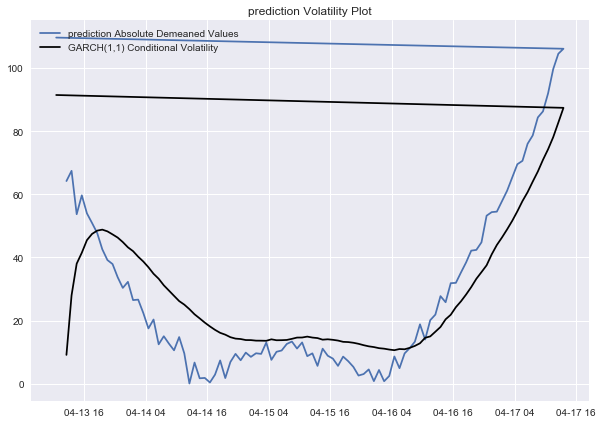

In [24]:
model.plot_fit()

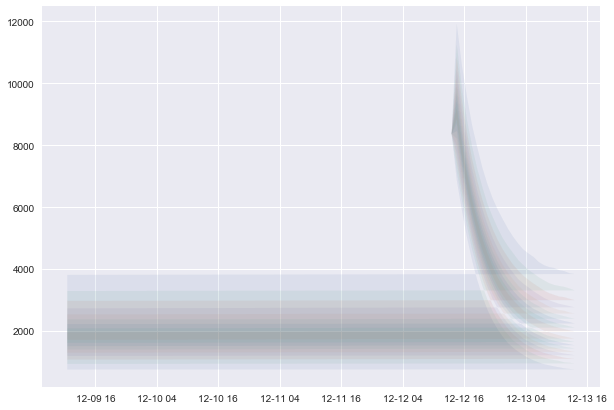

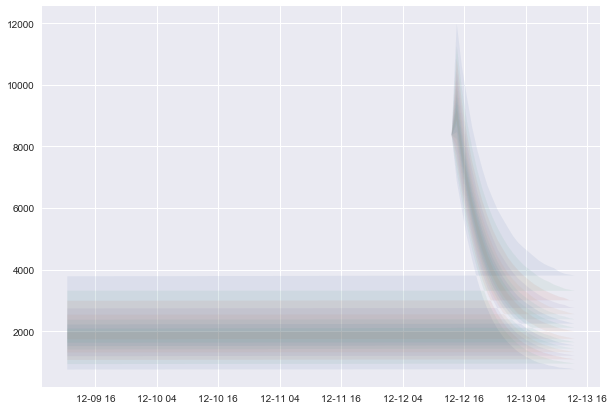

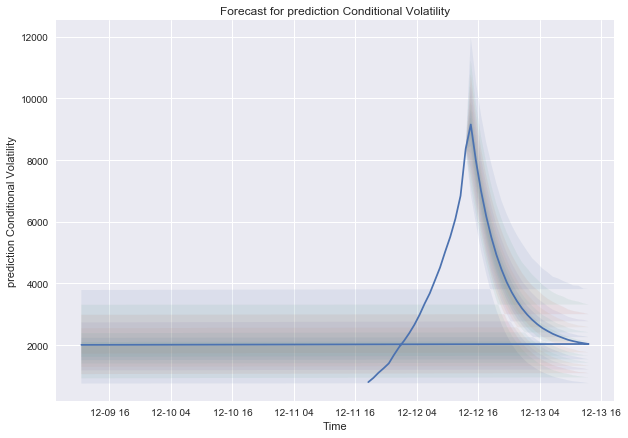

In [27]:
model.plot_predict(h=25)

In [60]:
from pandas_datareader.data import DataReader
a = DataReader('JPM',  'yahoo', pd.datetime(2006,6,1), pd.datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["JPM Returns"]
a_returns.head()

,JPM Returns
2006-06-02,0.005264
2006-06-05,-0.019360
2006-06-06,-0.013825
2006-06-07,-0.003073
2006-06-08,0.002364


In [61]:
#a_returns = a_returns.reset_index()
#a_returns = a_returns.drop(['index'], axis=1)
a_returns.index.name = 'timestamp'
a_returns.head()

,JPM Returns
timestamp,
2006-06-02,0.005264
2006-06-05,-0.019360
2006-06-06,-0.013825
2006-06-07,-0.003073
2006-06-08,0.002364


In [62]:
model = pf.GARCH(p=1, q=1, data=a_returns)
x = model.fit('M-H', nsims=20000)
x.summary()

Acceptance rate of Metropolis-Hastings is 0.0045
Acceptance rate of Metropolis-Hastings is 0.2964

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2973375
GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: JPM Returns                         Method: Metropolis Hastings                       
Start Date: 2006-06-05 00:00:00                         Unnormalized Log Posterior: 6435.2363             
End Date: 2016-06-02 00:00:00                           AIC: -12862.472534868963                          
Number of observations: 2517                            BIC: -12839.149242888421                          
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ===========

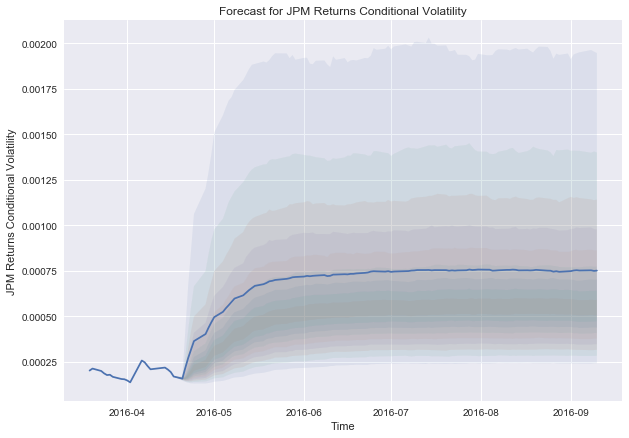

In [63]:
model.plot_predict(h=100)

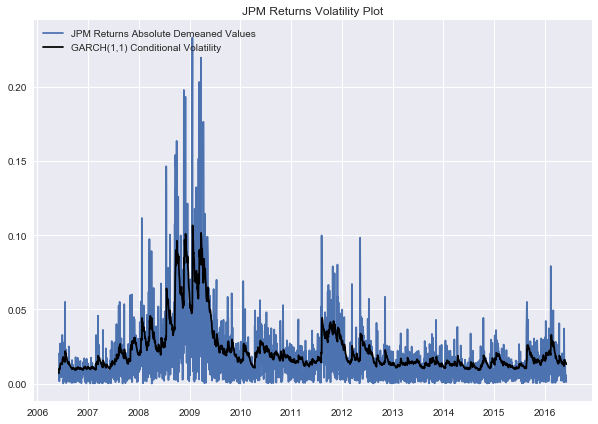

In [64]:
model.plot_fit()

In [67]:
predicted = model.predict(100).reset_index()
predicted.head()

,timestamp,JPM Returns
0,2016-04-20,0.000157
1,2016-04-21,0.000220
2,2016-04-22,0.000274
3,2016-04-23,0.000317
4,2016-04-24,0.000361
